# Traffic Sign Classification

### Importing Libraries

In [20]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.compat.v1 as tf
import tensorflow as tf2

np.random.seed(101)
%matplotlib inline

In [31]:
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [13]:
# Datatset used is the GTSRB Dataset

In [3]:
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

Dataset = namedtuple('Dataset', ['X', 'y'])

def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, n_labels, resize_to):
  images = []
  labels = []
  
  for c in range(n_labels):
    full_path = rootpath + '/' + format(c, '05d') + '/'
    for img_name in glob.glob(full_path + "*.ppm"):
      
      img = plt.imread(img_name).astype(np.float32)
      img = rgb2lab(img / 255.0)[:,:,0]
      if resize_to:
        img = resize(img, resize_to, mode='reflect')
      
      label = np.zeros((n_labels, ), dtype=np.float32)
      label[c] = 1.0
      
      images.append(img.astype(np.float32))
      labels.append(label)

  return Dataset(X = to_tf_format(images).astype(np.float32),
                 y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_ppm('GTSRB/Final_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


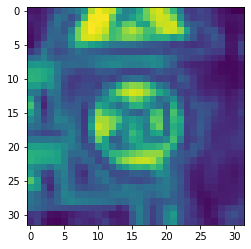

In [4]:
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[0, :]) #label

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


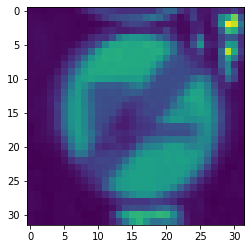

In [5]:
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE)) #sample
print(dataset.y[-1, :]) #label

In [6]:
from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


In [7]:
# Creating minibatches for data

def minibatcher(X, y, batch_size, shuffle):
  assert X.shape[0] == y.shape[0]
  n_samples = X.shape[0]
  
  if shuffle:
    idx = np.random.permutation(n_samples)
  else:
    idx = list(range(n_samples))
  
  for k in range(int(np.ceil(n_samples/batch_size))):
    from_idx = k*batch_size
    to_idx = (k+1)*batch_size
    yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [8]:
for mb in minibatcher(X_train, y_train, 10000, True):
  print(mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


### Building the Model

In [27]:
def fc_no_activation_layer(in_tensors, n_units):
  w = tf.get_variable('fc_W', 
    [in_tensors.get_shape()[1], n_units],
    tf.float32,
    tf.keras.initializers.glorot_normal())
  b = tf.get_variable('fc_B',
    [n_units, ],
    tf.float32,
    tf.constant_initializer(0.0))
  return tf.matmul(in_tensors, w) + b

def fc_layer(in_tensors, n_units):
  return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

def maxpool_layer(in_tensors, sampling):
  return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1], [1, sampling, sampling, 1], 'SAME')
  
def conv_layer(in_tensors, kernel_size, n_units):
  w = tf.get_variable('conv_W', 
    [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
    tf.float32,
    tf.keras.initializers.glorot_normal())
  b = tf.get_variable('conv_B',
    [n_units, ],
    tf.float32,
    tf.constant_initializer(0.0))
  return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1, 1, 1, 1], 'SAME') + b)

def dropout(in_tensors, keep_proba, is_training):
  return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba), lambda: in_tensors)

  
def model(in_tensors, is_training):
  
  # First layer: 5x5 2d-conv, 32 filters, 2x maxpool, 20% drouput
  with tf.variable_scope('l1'):
    l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
    l1_out = dropout(l1, 0.8, is_training)
  
  # Second layer: 5x5 2d-conv, 64 filters, 2x maxpool, 20% drouput
  with tf.variable_scope('l2'):
    l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
    l2_out = dropout(l2, 0.8, is_training)
    
  with tf.variable_scope('flatten'):
    l2_out_flat = tf.layers.flatten(l2_out)
  
  # Fully collected layer, 1024 neurons, 40% dropout 
  with tf.variable_scope('l3'):
    l3 = fc_layer(l2_out_flat, 1024)
    l3_out = dropout(l3, 0.6, is_training)
  
  # Output
  with tf.variable_scope('out'):
    out_tensors = fc_no_activation_layer(l3_out, N_CLASSES)
  
  return out_tensors

### Running and Evaluating the Model

In [28]:
# Disable Eager execution
tf.disable_eager_execution()

In [29]:
def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):

  in_X_tensors_batch = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
  in_y_tensors_batch = tf.placeholder(tf.float32, shape = (None, N_CLASSES))
  is_training = tf.placeholder(tf.bool)

  logits = model(in_X_tensors_batch, is_training)
  out_y_pred = tf.nn.softmax(logits)
  loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
  loss = tf.reduce_mean(loss_score)
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

  with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    for epoch in range(max_epochs):
      print("Epoch=", epoch)
      tf_score = []
      
      for mb in minibatcher(X_train, y_train, batch_size, shuffle = True):
        tf_output = session.run([optimizer, loss], 
                                feed_dict = {in_X_tensors_batch : mb[0], 
                                             in_y_tensors_batch : mb[1],
                                             is_training : True})
      
        tf_score.append(tf_output[1])
      print(" train_loss_score=", np.mean(tf_score))
    
    # after the training is done, time to test it on the test set
    print("TEST SET PERFORMANCE")
    y_test_pred, test_loss  = session.run([out_y_pred, loss], 
                                          feed_dict = {in_X_tensors_batch : X_test, 
                                                       in_y_tensors_batch : y_test,
                                                       is_training : False})
    
    print(" test_loss_score=", test_loss)
    y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
    y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
    print(classification_report(y_test_true_classified, y_test_pred_classified))
    
    cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    # And the log2 version, to enphasize the misclassifications
    plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
    plt.colorbar()
    plt.tight_layout()
    plt.show()

Epoch= 0
 train_loss_score= 3.648339
Epoch= 1
 train_loss_score= 0.5603376
Epoch= 2
 train_loss_score= 0.2546262
Epoch= 3
 train_loss_score= 0.1598986
Epoch= 4
 train_loss_score= 0.116359614
Epoch= 5
 train_loss_score= 0.089880526
Epoch= 6
 train_loss_score= 0.072571106
Epoch= 7
 train_loss_score= 0.06123672
Epoch= 8
 train_loss_score= 0.04915602
Epoch= 9
 train_loss_score= 0.057418864
TEST SET PERFORMANCE
 test_loss_score= 0.048157927
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        67
           1       0.98      0.98      0.98       539
           2       0.99      0.98      0.99       558
           3       0.98      0.97      0.98       364
           4       1.00      1.00      1.00       487
           5       0.98      0.97      0.97       479
           6       1.00      1.00      1.00       105
           7       1.00      0.98      0.99       364
           8       1.00      1.00      1.00       340
           9       

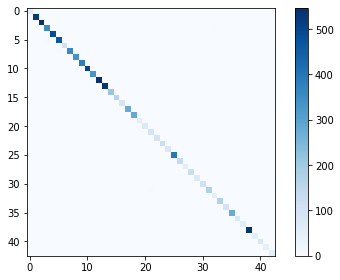

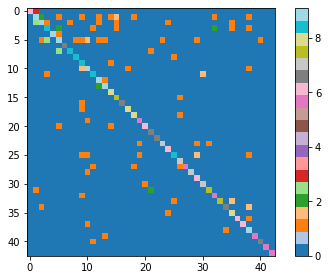

In [32]:
tf.reset_default_graph()
train_model(X_train, y_train, X_test, y_test, 0.001, 10, 256)